In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../bioAI.mplstyle')
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

import sys
sys.path.append('..')
import ca2_mec.project_path
import expipe_plugin_cinpla
import ca2_mec.dataloader as dl
import spatial_maps as sp
from ca2_mec.utils import cell_rate
from ca2_mec.plotting_functions import spike_track, axis_off_labels_on

In [3]:
project_path = ca2_mec.project_path.project_path()

project = expipe.get_project(project_path)
actions = project.actions

/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(


### Initialise data loader

In [13]:
lim = None#[0,1200] # limit recording times - in seconds
include_actions = ['001-181220-2', '001-181220-3', '001-181220-4', '001-181220-5', '001-181220-6']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_and_populate_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions


print("load #spikes: ", len(spikes))

"""
# correct for inconsistent mua-annotations
spikes = dl.correct_mua(spikes, only_good_mua=True)
print("#units after mua-corrections:", len(spikes))
spatial_map = sp.SpatialMap()

# SELECT brain region(s) to include cells from
spikes = dl.in_brain_regions(spikes, ['ca2'])
print("#units after brain region selection:", len(spikes))

# only include cells that are persistent across all actions
spikes = dl.persistent_units(spikes, include_actions)
print(f"Num spike_trains: {len(spikes)}. Num persistent units: {len(spikes) / len(include_actions)}")
"""

spatial_map = sp.SpatialMap()

/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(
/fp/projects01/ec109/software/expipe/expipe/core.py:700: UserWarning: Requested project with name 'hpc-social-nwb', but found 'hpc-social'
  warnings.warn(


load #spikes:  61


In [14]:
spikes.sort(key=lambda sptr: sptr.annotations["mua_quality"],reverse=True)
spikes.sort(key=lambda sptr: sptr.annotations["action_id"])
spikes.sort(key=lambda sptr: sptr.annotations["unit_idnum"])
spikes.sort(key=lambda sptr: len(sptr.annotations["persistent_trials"]),reverse=True)
include_actions.sort()

"""
for sptr in spikes:
    print(sptr.annotations["action_id"], sptr.annotations["unit_idnum"], len(sptr.annotations["persistent_trials"]))
"""
_=2

In [15]:
unique_unsorted_unit_idnums = []
for sptr in spikes:
    if sptr.annotations["unit_idnum"] not in unique_unsorted_unit_idnums:
        unique_unsorted_unit_idnums.append(sptr.annotations["unit_idnum"])

In [17]:
cell_rate(spikes[0])

(array(2.224) * 1/s, array(8.403) * Hz)

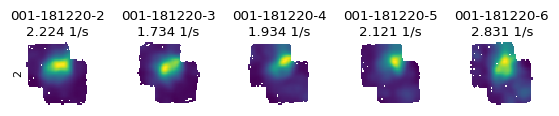

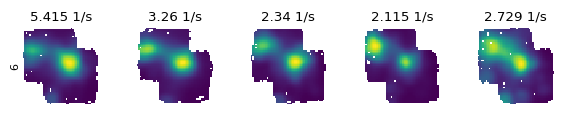

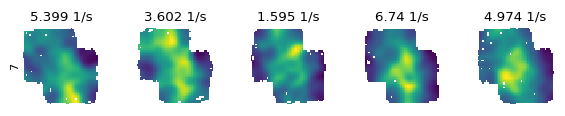

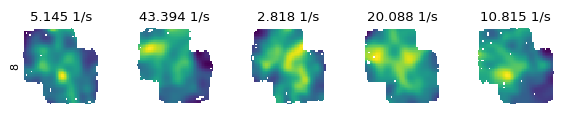

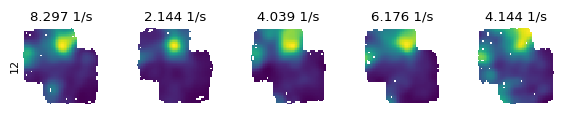

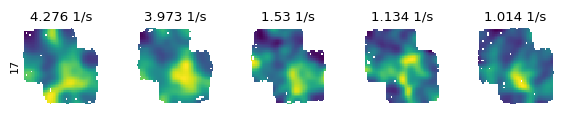

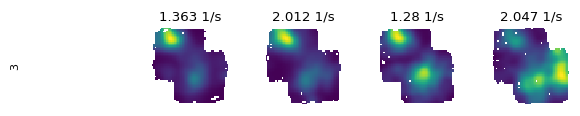

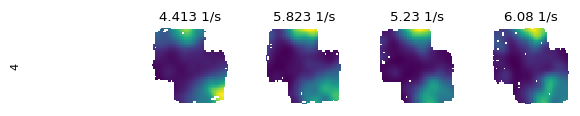

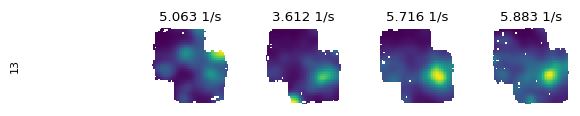

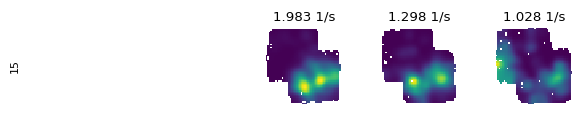

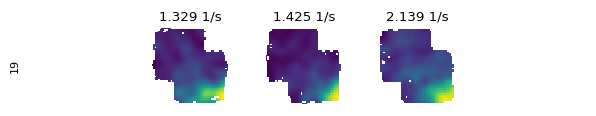

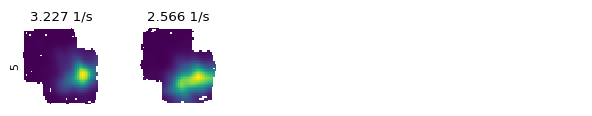

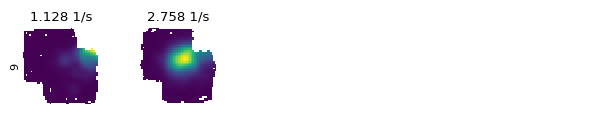

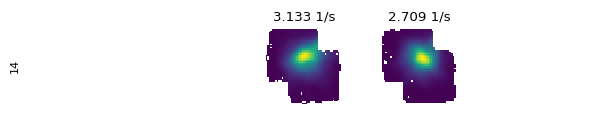

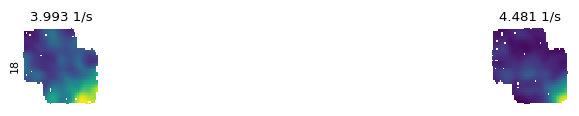

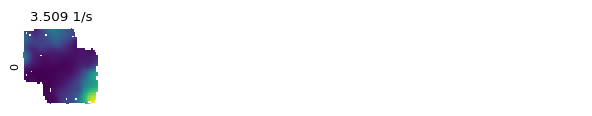

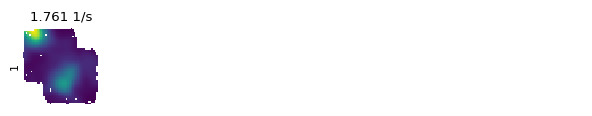

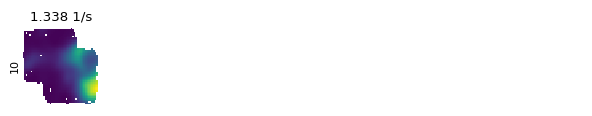

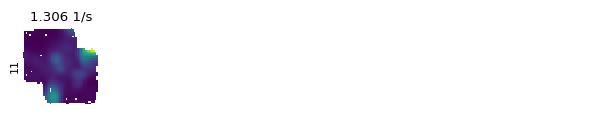

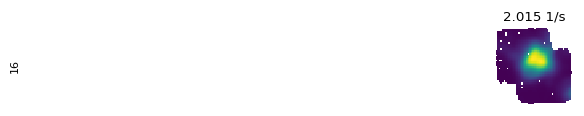

In [20]:
# sort on unit id
figscale = 1.2

add_title = True
for unit_idnum in unique_unsorted_unit_idnums:
    unit_spikes = [spike_train for spike_train in spikes if spike_train.annotations["unit_idnum"] == unit_idnum]
    fig,axs = plt.subplots(ncols=len(include_actions),figsize=(len(include_actions)*figscale, figscale))
    j=0
    for i in range(len(include_actions)):
        ax = axs[i]
        axis_off_labels_on(ax)
        if j == len(unit_spikes):
            continue
        spike_train = unit_spikes[j]
        action_id = spike_train.annotations["action_id"]
        if action_id != include_actions[i]:
            continue
        x,y,t,_ = tracking[action_id].T
        ratemap = spatial_map.rate_map(x, y, t, spike_train)
        ax.imshow(ratemap.T,origin='lower')
        j+=1
        # add action_id title to first few plots
        if add_title:
            ax.set_title(spike_train.annotations["action_id"] + "\n" + f"{cell_rate(spike_train)[0]}")
        else:
            # add average cell rate to ratemap title
            ax.set_title(cell_rate(spike_train)[0])
    add_title = False
    
    axs[0].set_ylabel(spike_train.annotations["unit_idnum"])
    
#    plt.savefig('./plots/MEC,'+str(unit_idnum)+'.pdf',dpi=300)

#    fig.savefig(f\"./plots/object-t1t2-{(spike_train.annotations['unit_idnum'])}.pdf\")